##### Aprendizaje para determinar Quasares

#### Ocupado el Notebook Regresión logistica usando gradiante descendiente v/s ’liblinear’

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
df2 = pd.read_csv("../datos/SDSS-DR14.csv")
df2.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


In [3]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      10000 non-null  float64
 1   ra         10000 non-null  float64
 2   dec        10000 non-null  float64
 3   u          10000 non-null  float64
 4   g          10000 non-null  float64
 5   r          10000 non-null  float64
 6   i          10000 non-null  float64
 7   z          10000 non-null  float64
 8   run        10000 non-null  int64  
 9   rerun      10000 non-null  int64  
 10  camcol     10000 non-null  int64  
 11  field      10000 non-null  int64  
 12  specobjid  10000 non-null  float64
 13  class      10000 non-null  object 
 14  redshift   10000 non-null  float64
 15  plate      10000 non-null  int64  
 16  mjd        10000 non-null  int64  
 17  fiberid    10000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


Podemos determinar que gran cantidad de datos forman parte de un formato numérico, por lo que no presentará problemas en la comparación y representación de los mismos.

In [4]:
df2.isnull().sum()

objid        0
ra           0
dec          0
u            0
g            0
r            0
i            0
z            0
run          0
rerun        0
camcol       0
field        0
specobjid    0
class        0
redshift     0
plate        0
mjd          0
fiberid      0
dtype: int64

Logramos ver ademas que basado en al dataset en su complejidad, no nos daría inconsistencias en cuanto al exceso de ruido que ésto pueda generar.

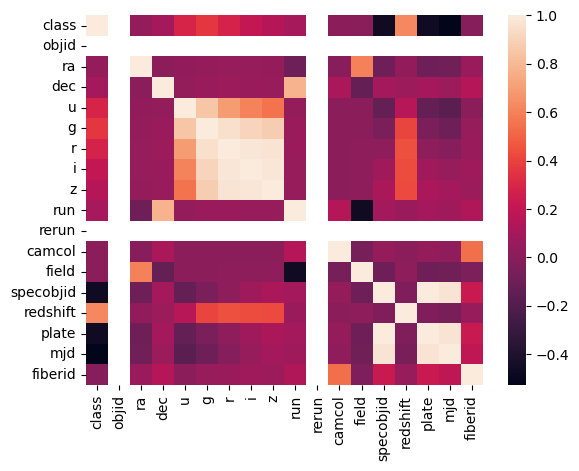

In [5]:
#código solamente para efecto práctico de mapa de calor
df2_test = df2[['class']]
df2_cp = df2
for n in range(df2_test.shape[0]):
    if df2_test.iloc[n,0] =='STAR':
        df2_test.iloc[n,0] = 1
    elif df2_test.iloc[n,0] =='GALAXY':
        df2_test.iloc[n,0] = 2
    elif df2_test.iloc[n,0] =='QSO':
        df2_test.iloc[n,0] = 3
df2_test.head()

df2_cut = df2_cp.drop(['class'],axis=1)
df2_plot = pd.concat([df2_test,df2_cut],axis=1)
#Print
sb.heatmap(df2_plot.corr())

#Restauro data
df2_data = df2

Se logra visualizar que "rerun" presenta una relación muy alta de dependencia con las demás variables, por lo que sería la principal candidata para ser eliminada del campo de apredizaje.

In [6]:
df2_data = df2_data.drop(['rerun'],axis=1)

<Axes: xlabel='class', ylabel='u'>

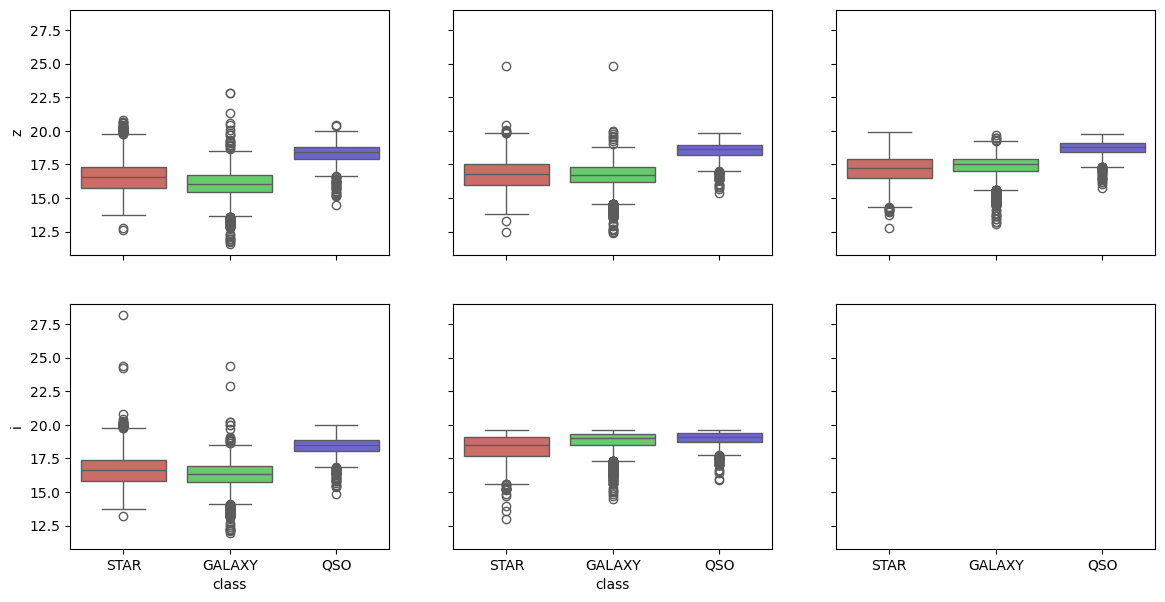

In [7]:
fig, axes = plt.subplots(2, 3,figsize=(14,7), sharex=True, sharey=True)
sb.boxplot(palette='hls', data=df2_data,x="class", y='z',ax=axes[0,0])
sb.boxplot(palette='hls', data=df2_data,x="class", y='r',ax=axes[0,1])
sb.boxplot(palette='hls', data=df2_data,x="class", y='g',ax=axes[0,2])
sb.boxplot(palette='hls', data=df2_data,x="class", y='i',ax=axes[1,0])
sb.boxplot(palette='hls', data=df2_data,x="class", y='u',ax=axes[1,1])

Los parámetros de luz z,r,g,i presentan una disparidad frente a la colección de datos QSO por lo que podrían presentar problemas en nuestras predicciones.

In [8]:
df2_data = df2_data.drop(['z','r','g','i'],axis=1)

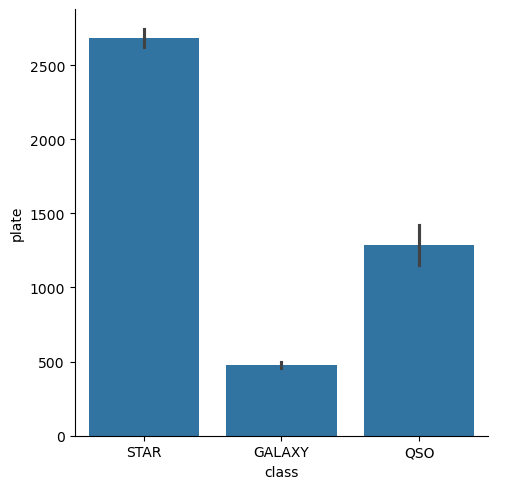

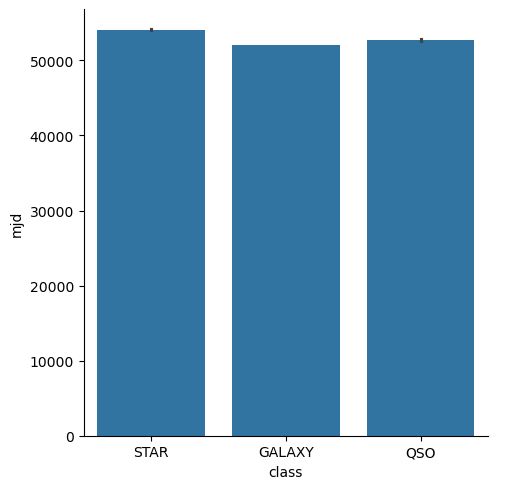

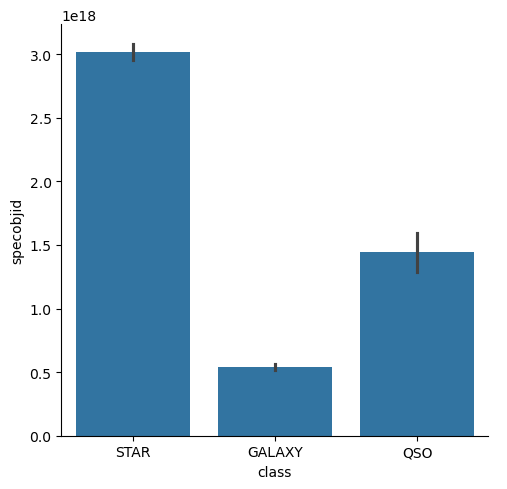

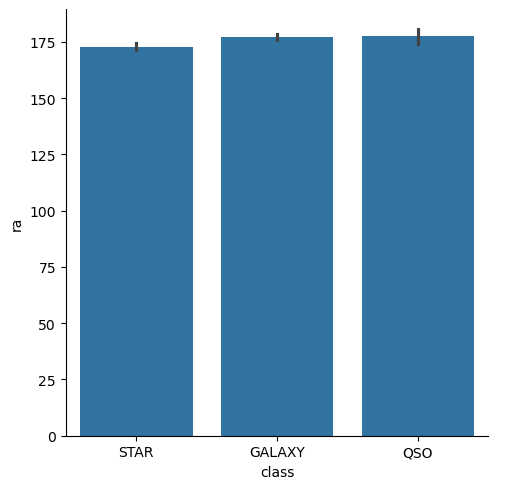

In [9]:
sb.catplot(kind='bar',data=df2_data,x="class", y='plate',ax=axes[0,0])
sb.catplot(kind='bar',data=df2_data,x="class", y='mjd',ax=axes[0,1])
sb.catplot(kind='bar',data=df2_data,x="class", y='specobjid',ax=axes[1,0])
sb.catplot(kind='bar',data=df2_data,x="class", y='ra',ax=axes[1,1])

Con los siguientes datos, cuales presentan un grado de relación muy bajo entre la estrella y un Quasar, por lo que se debe revisar si éstos no alteran la representación de clasificación

In [10]:
df2_data = df2_data.drop(['specobjid','plate'],axis=1)

### Transformación de clases a variables numéricas

Elimino todos los datos que están relacionados con estrellas, además de los parámetros de luz z,r,i cuales conforman disparidad en las medias de lo que queremos buscar que es para saber si es QUASAR

In [11]:
df2_data.head()

,objid,ra,dec,u,run,camcol,field,class,redshift,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,752,4,267,STAR,-0.000009,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,752,4,267,STAR,-0.000055,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,752,4,268,GALAXY,0.123111,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,752,4,269,STAR,-0.000111,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,752,4,269,STAR,0.000590,54922,512


In [12]:
df2_class = df2_data[['class']]
df2_dum = pd.get_dummies(df2_class)
df2_dum.head()

,class_GALAXY,class_QSO,class_STAR
0,False,False,True
1,False,False,True
2,True,False,False
3,False,False,True
4,False,False,True


In [13]:
df2_galaxy= df2_dum.drop(['class_GALAXY','class_STAR'],axis=1)
df2_full = df2_data.drop(['class'],axis=1)
df2_data = pd.concat([df2_galaxy,df2_full],axis=1)
df2_data.head()

,class_QSO,objid,ra,dec,u,run,camcol,field,redshift,mjd,fiberid
0,False,1.237650e+18,183.531326,0.089693,19.47406,752,4,267,-0.000009,54922,491
1,False,1.237650e+18,183.598370,0.135285,18.66280,752,4,267,-0.000055,51615,541
2,False,1.237650e+18,183.680207,0.126185,19.38298,752,4,268,0.123111,52023,513
3,False,1.237650e+18,183.870529,0.049911,17.76536,752,4,269,-0.000111,54922,510
4,False,1.237650e+18,183.883288,0.102557,17.55025,752,4,269,0.000590,54922,512


###  Revision del dataset

In [14]:
df2_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   class_QSO  10000 non-null  bool   
 1   objid      10000 non-null  float64
 2   ra         10000 non-null  float64
 3   dec        10000 non-null  float64
 4   u          10000 non-null  float64
 5   run        10000 non-null  int64  
 6   camcol     10000 non-null  int64  
 7   field      10000 non-null  int64  
 8   redshift   10000 non-null  float64
 9   mjd        10000 non-null  int64  
 10  fiberid    10000 non-null  int64  
dtypes: bool(1), float64(5), int64(5)
memory usage: 791.1 KB


In [15]:
df2_data.isnull().sum()

class_QSO    0
objid        0
ra           0
dec          0
u            0
run          0
camcol       0
field        0
redshift     0
mjd          0
fiberid      0
dtype: int64

In [16]:
df2_data.shape

(10000, 11)

### Proceso de entrenamiento y clasificación, usando gradiante descendiente

In [17]:
X = df2_data.iloc[:,1:df2_data.shape[1]].values
y = df2_data.iloc[:,0].values

In [18]:
def sigmoid(X, weight):
    z = np.dot(X, weight)
    return 1 / (1 + np.exp(-z))

def loss(h, y):
    return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

def gradient_descent(X, h, y):
    return np.dot(X.T, (h - y)) / y.shape[0]

def update_weight_loss(weight, learning_rate, gradient):
    return weight - learning_rate * gradient

def log_likelihood(x, y, weights):
    z = np.dot(x, weights)
    ll = np.sum( y*z - np.log(1 + np.exp(z)) )
    return ll

In [19]:
import time
start_time = time.time()

num_iter = 1000

intercept = np.ones((X.shape[0], 1)) 
X = np.concatenate((intercept, X), axis=1)
theta = np.zeros(X.shape[1])

for i in range(num_iter):
    h = sigmoid(X, theta)
    gradient = gradient_descent(X, h, y)
    theta = update_weight_loss(theta, 0.1, gradient)
    #print(theta)

print("Training time (Log Reg using Gradient descent):" + str(time.time() - start_time) + " seconds")
print("Learning rate: {}\nIteration: {}".format(0.1, num_iter))

Training time (Log Reg using Gradient descent):1.6449201107025146 seconds
Learning rate: 0.1
Iteration: 1000


In [20]:
result = sigmoid(X, theta)

In [21]:
print(result)

[0. 0. 0. ... 0. 0. 0.]


In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix = confusion_matrix(y, result)
print(confusion_matrix)
print(classification_report(y, result))

[[9150    0]
 [ 850    0]]
              precision    recall  f1-score   support

       False       0.92      1.00      0.96      9150
        True       0.00      0.00      0.00       850

    accuracy                           0.92     10000
   macro avg       0.46      0.50      0.48     10000
weighted avg       0.84      0.92      0.87     10000



## Usando algoritmo de aprendizaje a través de Scikit-Learn en la obtención de resultados

In [23]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)
#print(X_test)

In [25]:
#Aprendizaje
LogReg = LogisticRegression(max_iter=1000,penalty='l1',solver='liblinear')
LogReg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')

In [26]:
#Predicciones
y_pred = LogReg.predict(X_test)
y_pred

array([ True, False, False, ..., False, False, False])

In [27]:
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[2752,    1],
       [  35,  212]])

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      1.00      0.99      2753
        True       1.00      0.86      0.92       247

    accuracy                           0.99      3000
   macro avg       0.99      0.93      0.96      3000
weighted avg       0.99      0.99      0.99      3000



## Usando Oversampling para determinar refinamiento de datos sobre Quasar

In [30]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# define pipeline
steps = [('over', RandomOverSampler()), ('model', LogisticRegression())]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
score = mean(scores)
print('F1 Score: %.3f' % score)

F1 Score: 0.085
